In [1]:
!python /home/lkavenagh/Documents/Github/runs/upload_activities.py

Fetching activities from 2019-01-17 to 2019-01-25 (page 1)
Found 6 activities
Fetching activities from 2019-01-17 to 2019-01-25 (page 2)
Found 0 activities


In [2]:
import os
import psycopg2
import datetime

import seaborn as sns
sns.set()
sns.set_style("darkgrid")
sns.set_palette("bright")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

km_in_a_mile = 1.60934

def readConfig(key):
    if os.environ['DESKTOP_SESSION'] == 'ubuntu':
        config = pd.read_table(r'~/Documents/config.txt', header = None)
    else:
        config = pd.read_table(r'c:\users\barby\documents\config.txt', header = None)
    config = [c.split('=') for c in config[0]]
    out = [c[1] for c in config if c[0] == key][0]
    return(out)

def dbGetQuery(q):
    pw = readConfig('pw')
    conn_string = "host='kavdb.c9lrodma91yx.us-west-2.rds.amazonaws.com' dbname='kavdb' user='lkavenagh' password='" + pw + "'"
    conn = psycopg2.connect(conn_string)
    conn.autocommit = True
    dat = pd.read_sql(q, conn)
    conn.close()
    return(dat)

# YTD activities

In [3]:
dat = dbGetQuery('SELECT * FROM runs.activities_summary ORDER BY start_date')
print(dat[['name', 'start_date', 'distance_miles', 'average_pace', 'manual']].tail(20))

dat = dat.append(dat.tail(1)).reset_index(drop = True)
dat.loc[len(dat)-1, 'start_date'] = datetime.datetime.now()
dat.loc[len(dat)-1, 'distance'] = 0

dat['year'] = [c.year for c in dat.start_date]
dat['doy'] = [c.timetuple().tm_yday for c in dat.start_date]

dat['distance_miles'] = [c for c in dat.distance_miles]
dat['ytd_distance'] = dat.groupby('year', as_index = False).cumsum()['distance_miles']
dat['generic_date'] = [datetime.date(1904,c.month,c.day) for c in dat.start_date]


                                   name          start_date  distance_miles  \
1081  Final run of annual distance goal 2018-12-15 12:45:08        8.024097   
1082                          Lunch Run 2018-12-23 11:19:00        4.006984   
1083                        Morning Run 2018-12-29 10:15:39        2.420433   
1084                        Morning Run 2018-12-31 09:47:07        3.385363   
1085                        Evening Run 2019-01-02 18:50:00        2.000012   
1086                        Evening Run 2019-01-03 18:50:00        3.110033   
1087                          Lunch Run 2019-01-05 12:00:00        2.000012   
1088                        Evening Run 2019-01-07 18:10:00        2.000012   
1089                        Evening Run 2019-01-08 18:00:00        3.110033   
1090                        Evening Run 2019-01-09 18:30:00        2.000012   
1091     Speed warmup? Is that a thing? 2019-01-11 17:54:59        0.780133   
1092                        Evening Run 2019-01-14 1

In [4]:
target = 500

dat = dat[['start_date', 'generic_date', 'year', 'ytd_distance', 'distance_miles', 'doy']]

actual = dat.loc[dat.start_date == max(dat.start_date), 'ytd_distance'].item()

plot_dat = dat[['generic_date', 'year', 'ytd_distance']]
plot_dat = plot_dat.groupby(['generic_date', 'year'], as_index = False).max()
plot_dat = plot_dat.pivot_table(index = 'generic_date', columns = 'year')
plot_dat.columns = plot_dat.columns.droplevel().rename(None)
plot_dat = plot_dat.reset_index()
plot_dat = plot_dat.apply(lambda series: series.loc[:series.last_valid_index()].ffill())

x = range(len(plot_dat))
y = [(target / len(plot_dat)) * x for x in x]
plot_dat['target'] = y
t = datetime.datetime.today().date()
today_target = plot_dat.loc[plot_dat.generic_date == datetime.date(1904, t.month, t.day), 'target'].item()

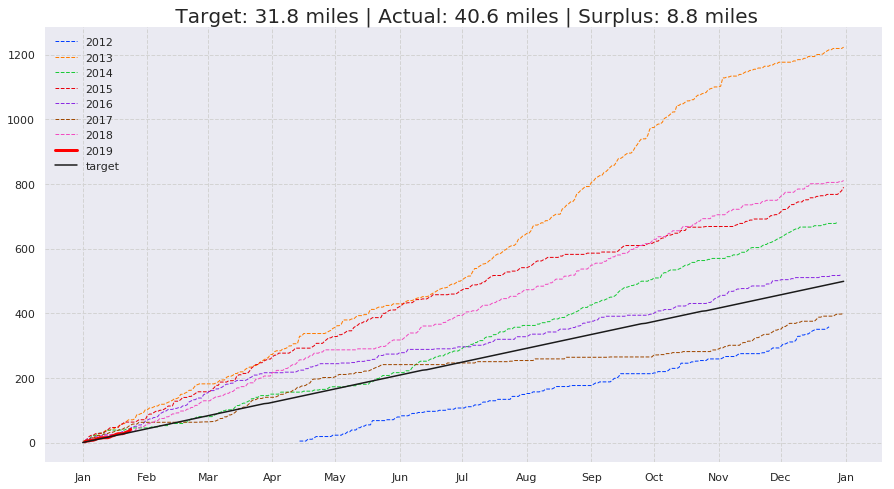

In [5]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

for y in plot_dat.columns[1:]:
    if y == 'target':
        ax.plot(plot_dat.generic_date, plot_dat[y], linestyle = '-', color = 'k')
    elif y == max([int(c) for c in plot_dat.columns[1:-1]]):
        ax.plot(plot_dat.generic_date, plot_dat[y], linewidth = 3, color = 'red')
    else:
        ax.plot(plot_dat.generic_date, plot_dat[y], linestyle = '--', linewidth = 1)

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')

ax.set_title(' Target: ' + str(round(today_target,1)) + ' miles |' + \
            ' Actual: ' + str(round(actual,1)) + ' miles |' + \
            ' Surplus: ' + str(round(actual - today_target,1)) + ' miles', fontsize = 20)

ax.set_xticks([datetime.date(1904,c,1) for c in range(1,13)] + [datetime.date(1905,1,1)])
xfmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(xfmt)

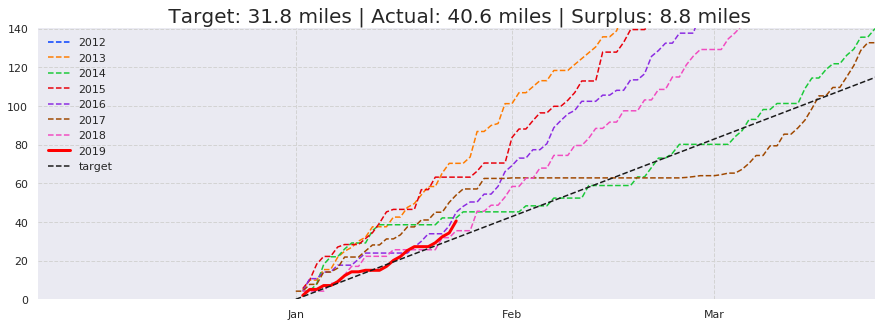

In [6]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

for y in plot_dat.columns[1:]:
    if y == 'target':
        ax.plot(plot_dat.generic_date, plot_dat[y], linestyle = '--', color = 'k')
    elif y == max([int(c) for c in plot_dat.columns[1:-1]]):
        ax.plot(plot_dat.generic_date, plot_dat[y], linewidth = 3, color = 'red')
    else:
        ax.plot(plot_dat.generic_date, plot_dat[y], linestyle = '--')

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')

ax.set_xticks([datetime.date(1904,c,1) for c in range(1,13)] + [datetime.date(1905,1,1)])

maxdate = plot_dat.loc[plot_dat[plot_dat.columns[-2]] == np.nanmax(plot_dat[plot_dat.columns[-2]]), 'generic_date'].head(1).item()
ax.set_xlim(maxdate - datetime.timedelta(60), maxdate + datetime.timedelta(60))

maxdistance = np.nanmax(plot_dat[plot_dat.columns[-2]])
ax.set_ylim(max(maxdistance - 100,0), maxdistance + 100)

ax.set_title(' Target: ' + str(round(today_target,1)) + ' miles |' + \
            ' Actual: ' + str(round(actual,1)) + ' miles |' + \
            ' Surplus: ' + str(round(actual - today_target,1)) + ' miles', fontsize = 20)

xfmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(xfmt)

# Miles by weekday

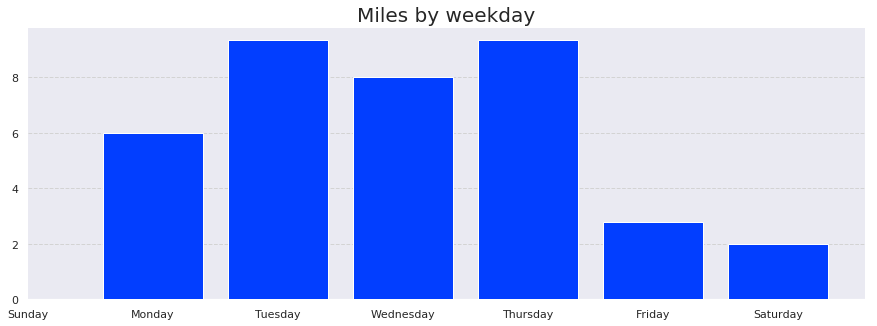

In [7]:
dat = dbGetQuery('SELECT EXTRACT(dow from start_date) as dow, sum(distance_miles) as total_miles \
                FROM runs.activities_summary \
                WHERE EXTRACT(year from start_date) = (SELECT max(EXTRACT(year from start_date)) FROM runs.activities) \
                GROUP BY 1 \
                ORDER BY 1')

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

ax.bar(dat.dow, dat.total_miles, zorder = 3)
ax.set_xticks([0,1,2,3,4,5,6])

for var in ['top', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)
ax.set_title('Miles by weekday', fontsize = 20)
x = ax.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

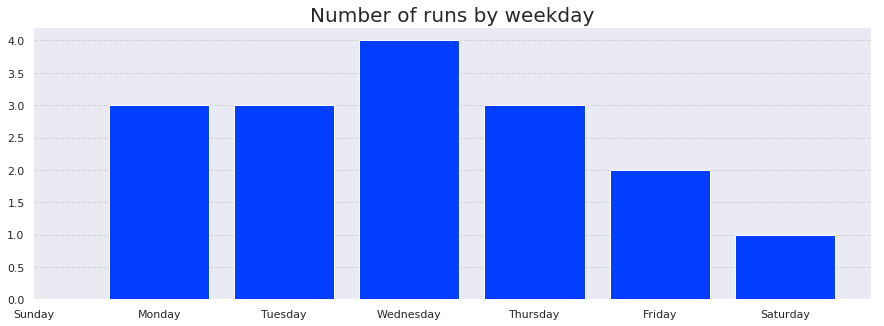

In [8]:
dat = dbGetQuery('SELECT EXTRACT(dow from start_date) as dow, count(distance_miles) as num_activities \
                FROM runs.activities_summary \
                WHERE EXTRACT(year from start_date) = (SELECT max(EXTRACT(year from start_date)) FROM runs.activities) \
                GROUP BY 1 \
                ORDER BY 1')

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

ax.bar(dat.dow, dat.num_activities, zorder = 3)
ax.set_xticks([0,1,2,3,4,5,6])

for var in ['top', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)
ax.set_title('Number of runs by weekday', fontsize = 20)
x = ax.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

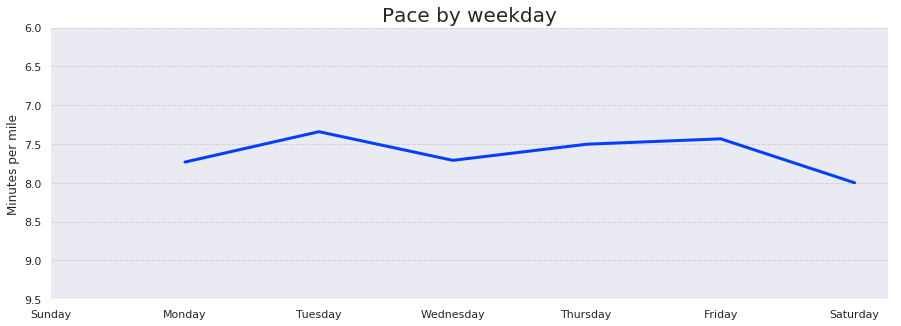

In [9]:
dat = dbGetQuery('SELECT EXTRACT(dow from start_date) as dow, sum(average_pace * distance_miles) / sum(distance_miles) as avg_pace \
                FROM runs.activities_summary \
                WHERE EXTRACT(year from start_date) = (SELECT max(EXTRACT(year from start_date)) FROM runs.activities) \
                GROUP BY 1 \
                ORDER BY 1')

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

ax.plot(dat.dow, dat.avg_pace, linewidth = 3)

for var in ['top', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)
ax.set_ylim([6,9.5])
ax.invert_yaxis()
ax.set_ylabel('Minutes per mile')
ax.set_title('Pace by weekday', fontsize = 20)
ax.set_xticks([0,1,2,3,4,5,6])
x = ax.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

# Average pace

In [10]:
dat = dbGetQuery('SELECT start_date, average_speed, distance FROM runs.activities \
                    WHERE type = \'Run\' \
                    and average_speed > 3')
dat = dat.sort_values('start_date').reset_index(drop = True)
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat['average_pace'] = [(km_in_a_mile/60)/((0.00001+c) / 1000) for c in dat.average_speed]
dat.distance = [(c/1000)/km_in_a_mile for c in dat.distance]

In [11]:
out = pd.DataFrame(columns = ['date', 'average_pace_7', 'average_pace_30', 'average_pace_YTD'])

for i in range(len(dat)):
    dat_7 = dat.loc[(dat.start_date <= dat.start_date[i]) & (dat.start_date >= (dat.start_date[i] - datetime.timedelta(7)))]
    dat_30 = dat.loc[(dat.start_date <= dat.start_date[i]) & (dat.start_date >= (dat.start_date[i] - datetime.timedelta(30)))]
    dat_YTD = dat.loc[(dat.start_date <= dat.start_date[i]) & (dat.start_date >= pd.Timestamp(datetime.date(dat.start_date[i].year,1,1)))]

    pace_y = pace_30 = pace_YTD = None
    if len(dat_7) > 0:
        pace_7 = np.nansum(dat_7.distance * dat_7.average_pace) / np.nansum(dat_7.distance)
    if len(dat_30) > 0:
        pace_30 = np.nansum(dat_30.distance * dat_30.average_pace) / np.nansum(dat_30.distance)
    if len(dat_YTD) > 0:
        pace_YTD = np.nansum(dat_YTD.distance * dat_YTD.average_pace) / np.nansum(dat_YTD.distance)

    out = out.append(pd.DataFrame([[dat.start_date[i].date(),
                            pace_7,
                            pace_30,
                            pace_YTD]], columns = ['date', 'average_pace_7', 'average_pace_30', 'average_pace_YTD']
                         ))
out = out.sort_values('date')

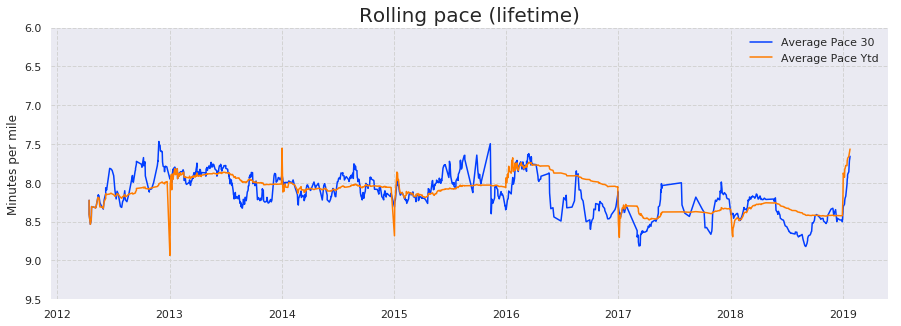

In [12]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

for y in out.columns[2:]:
    ax.plot(out.date, out[y], label = y.replace('_', ' ').title())

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')
ax.set_title('Rolling pace (lifetime)', fontsize = 20)
ax.set_ylim(6, 9.5)
ax.invert_yaxis()
ax.set_ylabel('Minutes per mile')

xfmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(xfmt)

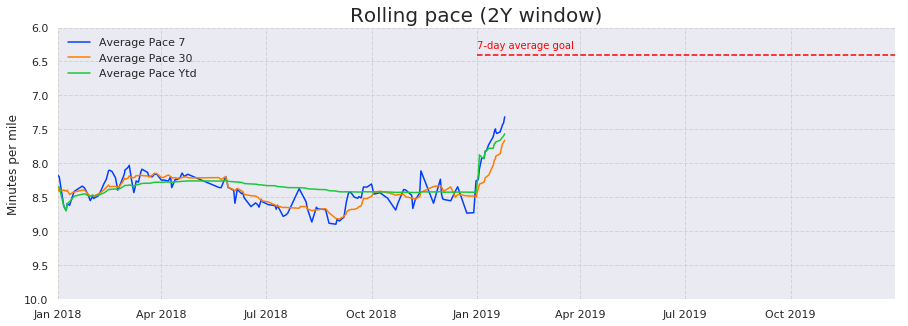

In [13]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

for y in out.columns[1:]:
    ax.plot(out.date, out[y], label = y.replace('_', ' ').title())

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')

ax.set_title('Rolling pace (2Y window)', fontsize = 20)
ax.set_xlim(datetime.date(max(out.date).year-1, 1, 1), datetime.date(max(out.date).year, 12, 31))
ax.set_ylim(6,10)
ax.invert_yaxis()
ax.set_ylabel('Minutes per mile')

ax.plot([datetime.date(2019,1,1), datetime.date(2019,12,31)], [6.4, 6.4], color = 'red', linestyle = '--')
ax.text(x = datetime.date(2019,1,1), y = 6.3, s = '7-day average goal', color = 'red')

xfmt = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(xfmt)

# Monthly elevation gain

In [14]:
dat = dbGetQuery('SELECT start_date, total_elevation_gain FROM runs.activities WHERE type = \'Run\'')
dat = dat.sort_values('start_date')
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat = dat.groupby('month', as_index = False).sum()
dat = dat.sort_values('month')

dat.month = [c.strftime('%b-%y') for c in dat.month]
dat = dat.reset_index(drop = True)

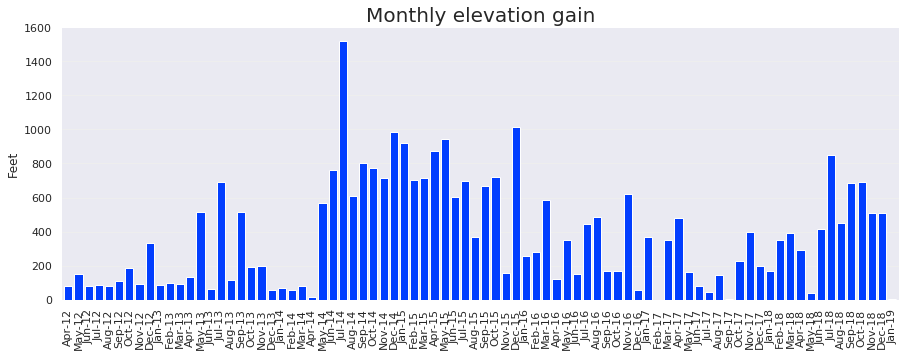

In [15]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

dat = dat.set_index('month')
dat.plot(kind = 'bar', ax = ax, width = 0.8)

ax.legend_.remove()
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Feet')
ax.set_title('Monthly elevation gain', fontsize = 20)
ax.grid(linestyle = '-', color = '#EEEEEE')
ax.xaxis.grid(False)

# Monthly mileage

In [16]:
dat = dbGetQuery('SELECT start_date, distance FROM runs.activities WHERE type = \'Run\'')
dat.distance = [(c/1000)/km_in_a_mile for c in dat.distance]
dat = dat.sort_values('start_date')
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat = dat.groupby('month', as_index = False).sum()
dat = dat.sort_values('month')
dat.month = [c.strftime('%b-%y') for c in dat.month]
dat = dat.reset_index(drop = True)

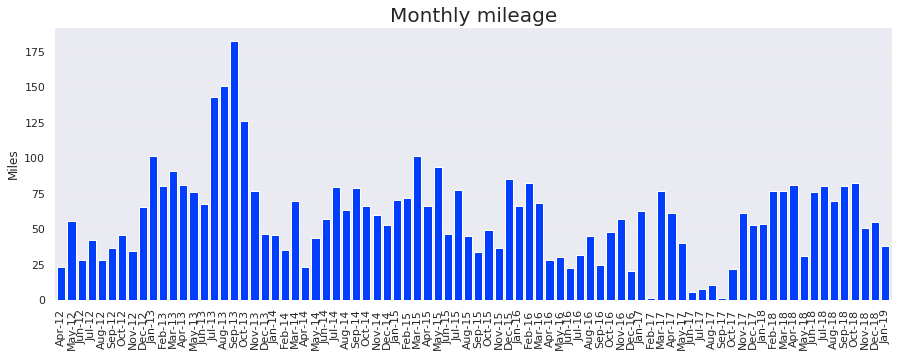

In [17]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

dat = dat.set_index('month')
dat.plot(kind = 'bar', ax = ax, width = 0.8)

ax.legend_.remove()
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Miles')
ax.set_title('Monthly mileage', fontsize = 20)
ax.grid(linestyle = '-', color = '#EEEEEE')
ax.xaxis.grid(False)